In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

from scipy.signal import correlate2d
from skimage.data import shepp_logan_phantom

In [3]:
def intensityTransform(Y, X, X_full=None, idx=None):
    ''' Perform Linear Regression to transform X into Y
        Y: vector (N) - US
        X: data matrix (N, C) - MRI intensity & gradient
        
        returns intensity transformed X
    '''
    N = Y.shape[0]
    
    # X = [A B 1] Where A is intensity, B is gradient mag, and 1 is ones
    X_feat = None
    
    if X_full is None:
        X_feat = np.concatenate((X, np.ones((N, 1))), axis=1)
    else:
        # if using the neighborhood, create vectors for the 4 pixels surrounding a pixel + their 4 gradients
        # TODO
        
        # Currently, takes average value of intensity and average value of gradient neighborhoods
        k = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / 4
        intsty_nbhd = correlate2d(X_full[:, :, 0], k, mode='same', boundary='symm')
        intsty_nbhd = np.expand_dims(intsty_nbhd.reshape(-1)[idx], 1)
        grad_nbhd = correlate2d(X_full[:, :, 1], k, mode='same', boundary='symm').reshape(-1)
        grad_nbhd = np.expand_dims(grad_nbhd.reshape(-1)[idx], 1)
        X_feat = np.concatenate((X, intsty_nbhd, grad_nbhd, np.ones((N, 1))), axis=1)
    
    # w = pinv(X)*y  --->  y_hat = Xw
    params = np.linalg.pinv(X_feat)@Y
    print(params)
    Y_hat = X_feat@params
    return Y_hat

# LC2 Code:
def lc2Similarity(img1, img2, extend=False):
    ''' img1: one channel image of size n*m (US)
        img2: multi-channel image of size n*m*c (MRI)
            c0 = image magnitude
            c1 = image gradient
        
        returns Linear Correlation of Linear Combination similarity measure:
        
    '''
    
    # Define similarity value
    similarity = -1
    
    img1 = img1.reshape(-1)
    img2_orig = img2
    img2 = img2.reshape(-1, img2.shape[2])
    
    num_pixels = img2.shape[0]
    idx = img1 > 0
    num_nonzero = np.sum(idx)
    
    Y = img1[idx]
    X = img2[idx]
    var_Y = np.var(Y)
    
    if var_Y > 1e-12:  # if variance is nonzero
        if num_nonzero > num_pixels/2:  # if more than half the pixels aren't zero
            Y_hat = intensityTransform(Y, X)
            if extend:
                Y_hat = intensityTransform(Y, X, X_full=img2_orig, idx=idx)
            mse = np.mean(np.power(Y - Y_hat, 2))
            print("mse:", mse)
            similarity = 1 - (np.var(Y - Y_hat) / var_Y)
            weight = np.sqrt(var_Y)
            measure = weight*similarity
    
    if (similarity == -1):
        similarity = 0
        weight = 0
        measure = 0
    
    return similarity, weight, measure


# LC2 assumes linear regression based on intensity + gradient + bias. What if we include neighborhood information?

# Two-stage matching process: geometric via SIFT + RANSAC (coarse), then iconic via LC2 (fine).

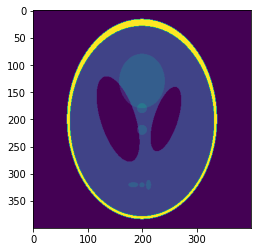

In [4]:
p = shepp_logan_phantom()
plt.imshow(p)

[ 1.00000000e+00  5.71941718e-15 -1.42464165e-16]
mse: 4.002557169177233e-31
[ 0.37597817 -0.07865702  0.09140213]
mse: 0.03980135175436197
[ 0.40876084 -0.04860838  0.08592736]
mse: 0.03847889114122453
[ 0.28255552 -0.11498597  0.10572359]
mse: 0.04258647802077752
[ 1.00000000e+00  5.71941718e-15 -1.42464165e-16]
[ 1.00000000e+00  3.64290575e-15  2.09901541e-15 -2.27758350e-15
  1.45283091e-17]
mse: 1.524128012368328e-30
[ 0.37597817 -0.07865702  0.09140213]
[-0.14263697  0.02164251  0.66953855 -0.35051667  0.07628763]
mse: 0.03801918967768469
[ 0.40876084 -0.04860838  0.08592736]
[-0.161238    0.00648107  0.72364328 -0.28193105  0.0698162 ]
mse: 0.03644323514223819
[ 0.28255552 -0.11498597  0.10572359]
[-0.10570158  0.03794697  0.51851135 -0.40824647  0.09370125]
mse: 0.0414150477988506


Text(0.5, 0.98, 'Noisy extended-LC2 evaluation')

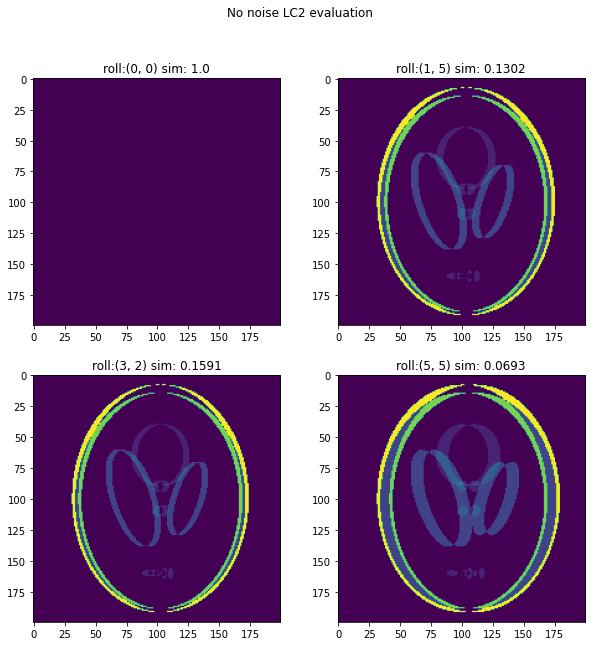

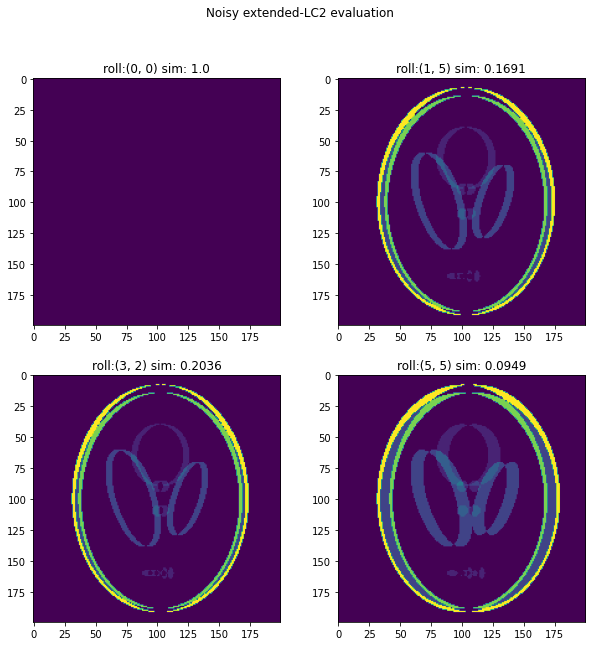

In [5]:
p = shepp_logan_phantom()
p = p[::2, ::2] + 0.02 # downsample by 2

# MRI (intensity and gradient)
p_grad = np.gradient(p)
p_grad = np.sqrt(np.power(p_grad[0], 2) + np.power(p_grad[1], 2))
p_mri = np.zeros((*p.shape, 2))
p_mri[:, :, 0] = p
p_mri[:, :, 1] = p_grad

# ROLL ONLY
rolls = [(0, 0), (1, 5), (3, 2), (5, 5)]
sims = []
ps = []
for i in range(4):
    ps.append(np.roll(p, rolls[i]))
    similarity, _, _ = lc2Similarity(ps[-1], p_mri)
    sims.append(similarity)

fig, axes = plt.subplots(2, 2)
for i, _ in enumerate(rolls):
    axes[i//2, i % 2].imshow(np.abs(ps[i] - p))
    axes[i//2, i % 2].set_title('roll:' + str(rolls[i]) + ' sim: ' + str(round(sims[i], 4)))
fig.set_size_inches(10, 10)
plt.suptitle("No noise LC2 evaluation")

# ROLL + EXTEND
rolls = [(0, 0), (1, 5), (3, 2), (5, 5)]
sims = []
ps = []
for i in range(4):
    ps.append(np.roll(p, rolls[i]))
    similarity, _, _ = lc2Similarity(ps[-1], p_mri, extend=True)
    sims.append(similarity)

fig, axes = plt.subplots(2, 2)
for i, _ in enumerate(rolls):
    axes[i//2, i % 2].imshow(np.abs(ps[i] - p))
    axes[i//2, i % 2].set_title('roll:' + str(rolls[i]) + ' sim: ' + str(round(sims[i], 4)))
fig.set_size_inches(10, 10)
plt.suptitle("Noisy extended-LC2 evaluation")


[0.80754179 0.07259442 0.12282754]
mse: 0.023471659500187505
[0.2621087  0.02148112 0.22988663]
mse: 0.05988618078517668
[0.2897641  0.05659801 0.22362464]
mse: 0.05878985428921388
[ 0.17751141 -0.03694366  0.24631105]
mse: 0.06191448317848023
[0.80754179 0.07259442 0.12282754]
[ 0.91226813 -0.05590173 -0.15794856  0.25054787  0.12827574]
mse: 0.02326947835219343
[0.2621087  0.02148112 0.22988663]
[-0.10020885 -0.04690859  0.43673701  0.007605    0.21897775]
mse: 0.05906923214888834
[0.2897641  0.05659801 0.22362464]
[-0.11511281 -0.06656345  0.47859776  0.11371572  0.21157235]
mse: 0.057697417325399965
[ 0.17751141 -0.03694366  0.24631105]
[-0.07939608  0.0203081   0.33174965 -0.17892472  0.23748774]
mse: 0.0614476742229599


Text(0.5, 0.98, 'Noisy extended-LC2 evaluation')

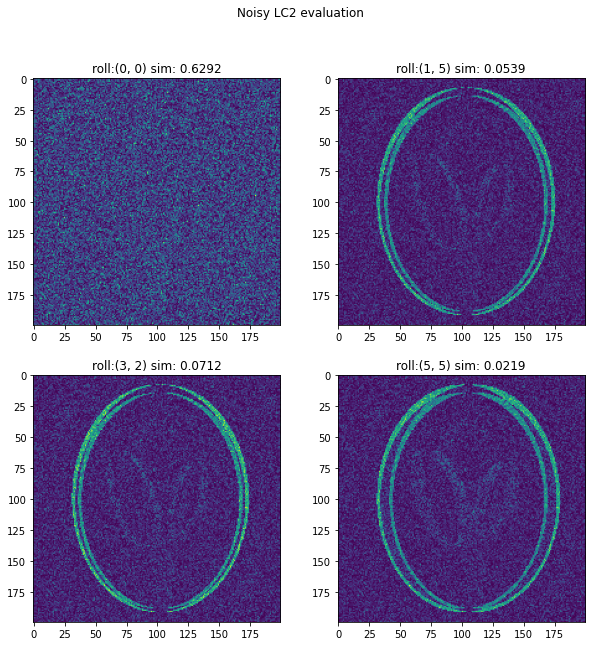

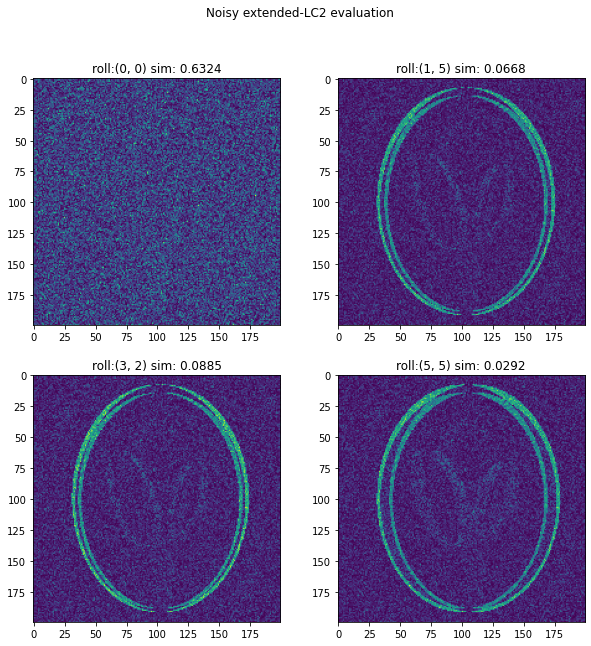

In [6]:
# ROLL + NOISE
noisy_p = p + 0.2*np.random.normal(0, 1, size=p.shape)
rolls = [(0, 0), (1, 5), (3, 2), (5, 5)]
sims = []
noisy_ps = []
for i in range(4):
    noisy_ps.append(np.roll(noisy_p, rolls[i]))
    similarity, _, _ = lc2Similarity(noisy_ps[-1], p_mri)
    sims.append(similarity)

fig, axes = plt.subplots(2, 2)
for i, _ in enumerate(rolls):
    axes[i//2, i % 2].imshow(np.abs(noisy_ps[i] - p))
    axes[i//2, i % 2].set_title('roll:' + str(rolls[i]) + ' sim: ' + str(round(sims[i], 4)))
fig.set_size_inches(10, 10)
plt.suptitle("Noisy LC2 evaluation")

# ROLL + NOISE + EXTEND
rolls = [(0, 0), (1, 5), (3, 2), (5, 5)]
sims = []
noisy_ps = []
for i in range(4):
    noisy_ps.append(np.roll(noisy_p, rolls[i]))
    similarity, _, _ = lc2Similarity(noisy_ps[-1], p_mri, extend=True)
    sims.append(similarity)

fig, axes = plt.subplots(2, 2)
for i, _ in enumerate(rolls):
    axes[i//2, i % 2].imshow(np.abs(noisy_ps[i] - p))
    axes[i//2, i % 2].set_title('roll:' + str(rolls[i]) + ' sim: ' + str(round(sims[i], 4)))
fig.set_size_inches(10, 10)
plt.suptitle("Noisy extended-LC2 evaluation")

In [14]:
model = keras.Sequential()
model.add(keras.layers.Dense(400, input_shape=(80000,), activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(40000, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(p_mri.reshape(-1)[np.newaxis, :], noisy_p.reshape(-1)[np.newaxis, :], epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0666 - mse: 0.0666
Epoch 2/100
1/1 [==============================] - 0s 250ms/step - loss: 0.0690 - mse: 0.0690
Epoch 3/100
1/1 [==============================] - 0s 247ms/step - loss: 0.0558 - mse: 0.0558
Epoch 4/100
1/1 [==============================] - 0s 226ms/step - loss: 0.0369 - mse: 0.0369
Epoch 5/100
1/1 [==============================] - 0s 305ms/step - loss: 0.0264 - mse: 0.0264
Epoch 6/100
1/1 [==============================] - 0s 335ms/step - loss: 0.0130 - mse: 0.0130
Epoch 7/100
1/1 [==============================] - 0s 232ms/step - loss: 0.0097 - mse: 0.0097
Epoch 8/100
1/1 [==============================] - 0s 215ms/step - loss: 0.0085 - mse: 0.0085
Epoch 9/100
1/1 [==============================] - 0s 222ms/step - loss: 0.0072 - mse: 0.0072
Epoch 10/100
1/1 [==============================] - 0s 244ms/step - loss: 0.0056 - mse: 0.0056
Epoch 11/100
1/1 [==============================] - 0s 237ms/s

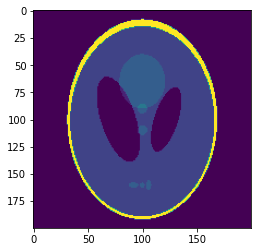

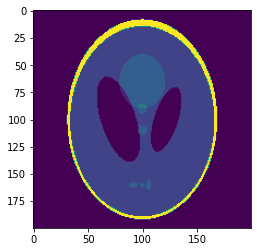

In [20]:
noisy_p_predict = model.predict(p_mri.reshape(-1)[np.newaxis, :])
plt.imshow(noisy_p_predict.reshape(p.shape))
plt.figure()
plt.imshow(noisy_p)